In [1]:
# this file takes in all files and produce the appropriate s2d analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8-whitegrid') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [4]:
root_path = Path("/home/vente/repos/nlgs-research")


INPUT_TO_ANALYSE = ""

# TODO: get this file form argv so driver code can run all analyses in a loop
[pkl, *rest] = list( (root_path / "pipeline/predictions").glob("*s2d*"))
pkl.name

's2d-t5-small-5.pkl'

In [5]:
OUTPUT_PATH = Path("/home/vente/repos/nlgs-research/pipeline/scores") / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/s2d-t5-small-5')

In [6]:
corpus = pd.read_pickle(root_path / "pipeline/normalized_data/webnlg_clean.pkl")
test_predictions = pd.read_pickle(pkl)
test_corpus = corpus[corpus['subset']=='test']
test_corpus 

,subset,category,index,sd,nl
14495,test,Airport,0,"Abilene Regional Airport|city served|Abilene, ...","Abilene, Texas is served by the Abilene region..."
14496,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas Airport can be fo...
14497,test,Airport,2,Adolfo Suarez Madrid-Barajas Airport|runway na...,The runway name of Adolfo Suarez Madrid-Baraja...
14498,test,Airport,3,Afonso Pena International Airport|i c a o loc...,Afonso Pena International Airport ICAO Locatio...
14499,test,Airport,4,Afonso Pena International Airport|city served|...,Afonso Pena International Airport serves the c...
...,...,...,...,...,...
16090,test,University,1595,Acharya Institute of Technology|was given the ...,The Acharya Institute of Technology in Karnata...
16091,test,University,1596,Romania|ethnic group|Germans of Romania; Roman...,The Germans of Romania are one of the ethnic g...
16092,test,University,1597,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...
16093,test,University,1598,School of Business and Social Sciences at the ...,Denmark is led by the Monarchy of Demark and t...


In [7]:
compute_rouge = lambda x,y: rouge.compute(references=[x], predictions=[x], use_stemmer=False, use_aggregator=False, rouge_types=['rouge2'])

test_predictions['decoded']

0       Abilene Regional Airport|city served|Abilene, ...
1       Adolfo Suarez Madrid-Barajas Airport|location|...
2       Adolfo Suarez Madrid-Barajas Airport|runway na...
3       Afonso Pena International Airport|i c a o loca...
4       Afonso Pena International Airport|city served|...
                              ...                        
1595    Acharya Institute of Technology|country|Karnat...
1596    Romania|leader name|Klaus Iohannis; Romania|et...
1597    School of Business and Social Sciences at the ...
1598    School of Business and Social Sciences at the ...
1599    School of Business and Social Sciences at the ...
Name: decoded, Length: 1600, dtype: object

In [8]:
test_predictions

,index,pred_ids,decoded,subset
0,0,"[0, 891, 23, 14205, 7676, 5735, 9175, 6726, 20...","Abilene Regional Airport|city served|Abilene, ...",test
1,1,"[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,test
2,2,"[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|runway na...,test
3,3,"[0, 71, 89, 106, 7, 32, 4511, 9, 1331, 5735, 9...",Afonso Pena International Airport|i c a o loca...,test
4,4,"[0, 71, 89, 106, 7, 32, 4511, 9, 1331, 5735, 9...",Afonso Pena International Airport|city served|...,test
...,...,...,...,...
1595,1595,"[0, 14217, 1208, 9, 2548, 13, 3669, 9175, 1752...",Acharya Institute of Technology|country|Karnat...,test
1596,1596,"[0, 3871, 9175, 22900, 564, 9175, 439, 40, 206...",Romania|leader name|Klaus Iohannis; Romania|et...,test
1597,1597,"[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,test
1598,1598,"[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,test


 How do we formulate F-measure for this task? Usually there is a fixed number
 of classes, and one label per class. But this class is fundimentally about
 extracting many labels from a single sequence.
 Approach: treat one data sample as multiple classification events, compute the
 f-measure across each label in an needs to be order-insensitive by comparing
 the sets themselves

 ```
 TP <- PRED `intersect` GT |> length
 FP <- GT - PRED |> length
 FN <- PRED - GT |> length
 F1 <- harmonic_mean(prec, recl)
 prec <- TP / (TP + FP)
 recl <- TP / (TP + FN)
 ```

In [9]:
# define set notion of precision when multiple labels are assigned
# to a single instance, with epsilon preventing div by zero
def compute_f_measure(pred: set[str], gt: set[str], epsilon=1e-99):
    tp = len(pred.intersection(gt)) # pred true and actually true
    fp = len(gt - pred)             # in pred but not in gt
    fn = len(pred - gt)             # not in pred but actualy true

    prec = tp / (tp + fp + epsilon) 
    recl = tp / (tp + fn + epsilon) 
    f1 = (2 * prec * recl) / (prec + recl + epsilon)
    return f1

 ## Unit Tests

In [10]:
assert compute_f_measure(set("a"), set('a')) == 1
assert compute_f_measure(set("ab"), set('a')) == 2/3
assert compute_f_measure(set() , set('a')) == 0

In [11]:
# don't penalize for quotes or spaces
norm_split_set = lambda x: x.str.upper().str.replace("'", '').str.replace(' ','').map(_.split(";")).map(set)
y_pred = norm_split_set(test_predictions['decoded'])
y_pred

0       {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
1       {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
2       {ADOLFOSUAREZMADRID-BARAJASAIRPORT|RUNWAYNAME|...
3       {AFONSOPENAINTERNATIONALAIRPORT|ICAOLOCATIONID...
4       {AFONSOPENAINTERNATIONALAIRPORT|CITYSERVED|CUR...
                              ...                        
1595    {KARNATAKA|HASTOITSNORTHEAST|TELANGANA, ACHARY...
1596    {ROMANIA|ANTHEM|DESTEAPTA-TE,ROMANE!, ROMANIA|...
1597    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
1598    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
1599    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: decoded, Length: 1600, dtype: object

In [12]:
y_true = norm_split_set(test_corpus['sd'])
y_true

14495    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
14496    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
14497    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|RUNWAYNAME|...
14498    {AFONSOPENAINTERNATIONALAIRPORT|ICAOLOCATIONID...
14499    {AFONSOPENAINTERNATIONALAIRPORT|CITYSERVED|CUR...
                               ...                        
16090    {KARNATAKA|HASTOITSWEST|ARABIANSEA, KARNATAKA|...
16091    {ROMANIA|ANTHEM|DESTEAPTA-TE,ROMANE!, ROMANIA|...
16092    {DENMARK|LEADERNAME|LARSLOKKERASMUSSEN, SCHOOL...
16093    {EUROPEANUNIVERSITYASSOCIATION|HEADQUARTERS|BR...
16094    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: sd, Length: 1600, dtype: object

In [13]:
f1_scores = seq(y_pred).zip(y_true).starmap(compute_f_measure).to_list()
f1_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [14]:
def compute_closest_edit_dists(y_pred, y_true):
    # we need an alignment of the labels by edit distance
    return (
      seq(y_pred)
        .cartesian(y_true)
        .starmap(edit_distance) 
        .sorted()
        # full penalty for missed guesses or too many guesses
        .take(seq(y_true, y_pred).map(len).max())
        .to_list()
    )

edit_distances = (
  seq(y_pred)
    .zip(y_true)
    .starmap(compute_closest_edit_dists)
    .map(np.mean)
    .to_list()
)
edit_distances 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 12.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 26.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 28.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 14.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 14.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.0,
 0.0,
 0.0,
 3.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 12.0,
 0.0,
 0.0,
 15.0,
 0.0,
 1.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 16.0,
 0.0,
 0.0,
 0.0,
 0.0,
 48.0,
 0.0,
 0.0,
 1.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [15]:
results = pd.merge(corpus, test_predictions)
results['f1_scores'] = f1_scores
results['med_scores'] = edit_distances # med mean edit distance

In [16]:
# let's define nth finish and "place-number" as 0 for "finishing in first place"
# give find the place-number given a score: ties should have the same place
score_to_nth_finish: dict[float, int]= (
  seq(f1_scores)
    .sorted(reverse=True) # Highest to lowest
    .zip_with_index()     # gives an over-estimate of nth-finish
    .group_by(get[0])     # so we group by the f1 scores
    .map(get[1])          # then we get the actual place of the score
    .map(get[0])          # it's sorted, so take the first to account for ties
    .to_dict()            # convert to dictionary
)
seq(score_to_nth_finish.items()).to_pandas()

,0,1
0,1.000000,0
1,0.923077,699
2,0.909091,702
3,0.888889,707
4,0.857143,781
5,0.833333,899
6,0.833333,902
7,0.800000,908
8,0.800000,918
9,0.769231,997


  so we can sort by this key later, and also get a broad impression
 of the distribution of errors. Later we'll plot a histogram anyway.

 ## Error analysis

In [17]:
results['nth_finish'] = results['f1_scores'].map(score_to_nth_finish)
results['nth_finish'] 

0          0
1          0
2          0
3          0
4          0
        ... 
1595    1447
1596     902
1597    1299
1598    1066
1599    1055
Name: nth_finish, Length: 1600, dtype: int64

In [18]:
results[['nth_finish','med_scores', 'f1_scores', 'decoded','sd']].round(3).to_csv('vis.csv')

In [19]:
# 
worst_finishes = results[results.f1_scores == 0]
dspl_html(worst_finishes[['med_scores','f1_scores', 'decoded','sd']].to_html())
print(len(worst_finishes))

,med_scores,f1_scores,decoded,sd
14,2.000000,0.0,Andrews County Airport|runway length|896,Andrews County Airport|runway length|896.0
24,10.000000,0.0,Belgium|language|Netherlands language,Belgium|language|Dutch language
26,1.000000,0.0,Denmark|demonym|Dänes,Denmark|demonym|Danes
43,7.000000,0.0,Agustin Barboza|genre|Guarania,Agustin Barboza|genre|Guarania (music)
55,12.500000,0.0,"Alison O'Donnell|genre|Sound, percussion, autoharp; Alison O'Donnell|instrument|Bodhran, percussion, autoharp","Alison O'Donnell|instrument|Voice, bodhran, percussion, autoharp"
62,26.000000,0.0,Christian Burns|associated band/associated musical artist|Andrew Rayel,Andrew Rayel|associated band/associated musical artist|Christian Burns
70,5.000000,0.0,RCA Records|distributing company|Samsung Music Entertainment,RCA Records|distributing company|Sony Music Entertainment
74,28.000000,0.0,Buzz Aldrin|was a backup pilot on the Apollo 8 mission,Apollo 8|backup pilot|Buzz Aldrin
78,3.000000,0.0,California|stone|Benitoite,California|gemstone|Benitoite
81,14.000000,0.0,Elliot See|death place|Elliot See,Elliot See|status|Deceased


106


In [20]:
len(results)

1600

<Axes: >

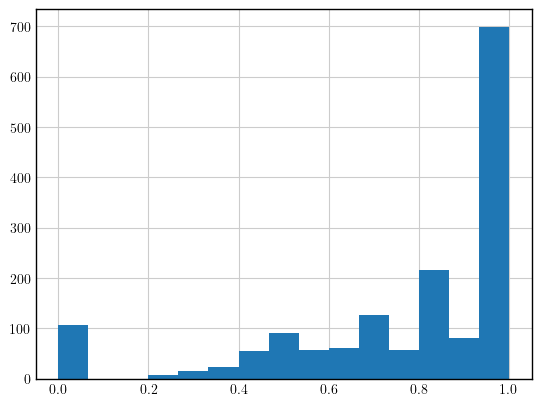

In [21]:
results['f1_scores'].hist(bins=15)

<Axes: >

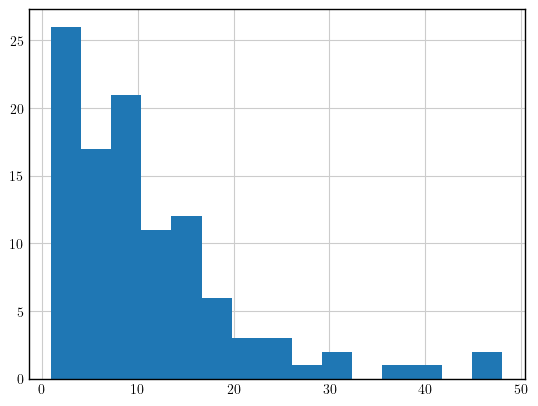

In [22]:
worst_finishes['med_scores'].hist(bins=15)

<Axes: >

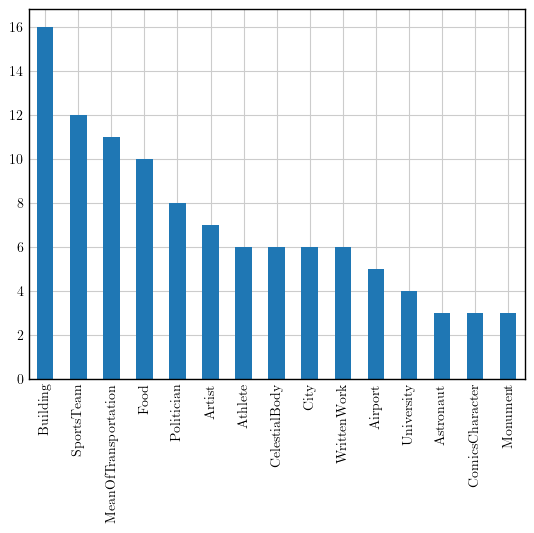

In [23]:
worst_finishes.category.value_counts().plot.bar()

<Axes: >

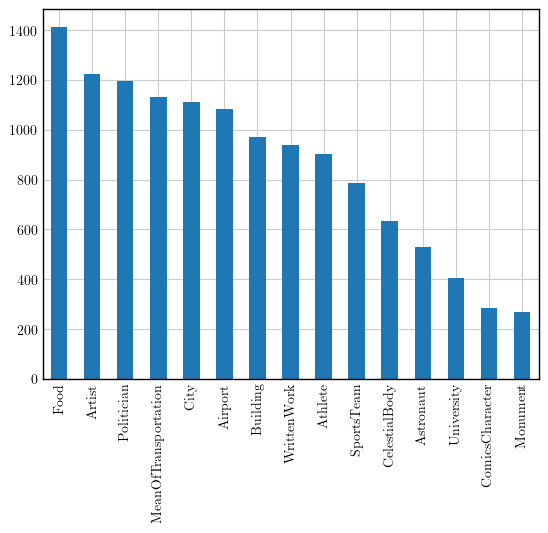

In [24]:
train_corpus = corpus[corpus.subset == 'train']
train_corpus.category.value_counts().plot.bar()

<Axes: >

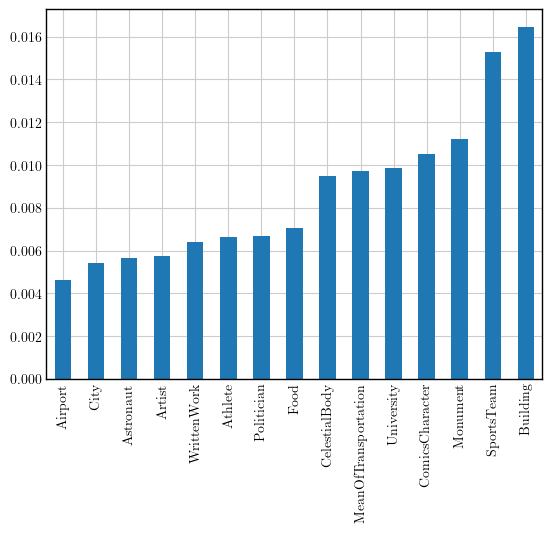

In [25]:
# normalized performance by category
npc = worst_finishes.category.value_counts() / train_corpus.category.value_counts()
npc.sort_values().plot.bar()

 the network performs poorly on buildings, sports teams, and monuments when
 normalized for class prevalence. Poor performance on monument may be explained
 by its under-representation in the training set. This does not hold for sports
 teams and monuments, which have good representation in the training set but do
 not have good performance. This points to qualitative features particular to
 entries in those categories.